In [2]:
import os 
import sys
src_path = os.path.abspath("Hierarchical-Localization-Core/")
if src_path not in sys.path:
    sys.path.append(src_path)

In [3]:
from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_retrieval,
    pairs_from_exhaustive,
)

from hloc.visualization import plot_images, read_image
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster
import pycolmap
from pathlib import Path
import config

In [7]:
conf_path=config.confs['BCEF_2']
conf_path

{'feature_path': WindowsPath('Hierarchical-Localization-Core/outputs/BCEF-2/feats-superpoint-n4096-r1024.h5'),
 'match_path': WindowsPath('Hierarchical-Localization-Core/outputs/BCEF-2/feats-superpoint-n4096-r1024_matches-superglue_pairs-netvlad.h5'),
 'retrieval_path': WindowsPath('Hierarchical-Localization-Core/outputs/BCEF-2/global-feats-netvlad.h5'),
 'model_point': WindowsPath('Hierarchical-Localization-Core/outputs/BCEF-2/sfm_superpoint+superglue')}

In [30]:
retrieval_conf_loc = extract_features.confs["netvlad"]
feature_conf_loc = extract_features.confs["superpoint_aachen"]
matcher_conf_loc = match_features.confs["NN-superpoint"]

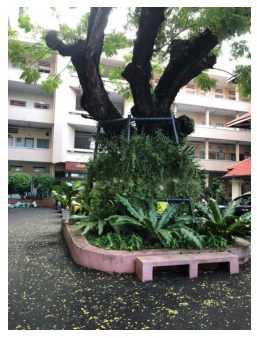

In [31]:
images_query = Path("query/Outdoor/query")
image_name="35.jpg"
plot_images([read_image(images_query/image_name)], dpi=75)

In [32]:
extract_features.main(feature_conf_loc, images_query, image_list=[image_name], feature_path=feature_path, overwrite=True)

[2024/12/19 13:00:05 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 2048, 'name': 'superpoint', 'nms_radius': 1},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 512}}


hloc.extractors.superpoint
Loaded SuperPoint model


d:\DATN\hloc\Hierarchical-Localization\hloc\extractors\..\..\third_party\SuperGluePretrainedNetwork\models\superpoint.py:137: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

1

WindowsPath('outputs/Outdoor2/feats-superpoint-n4096-r1024.h5')

In [33]:
extract_features.main(retrieval_conf_loc, images_query, export_dir=outputs,image_list=[image_name],overwrite=True)

[2024/12/19 13:00:08 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 512}}


hloc.extractors.netvlad


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]
[2024/12/19 13:00:16 hloc INFO] Finished exporting features.


WindowsPath('outputs/Outdoor2/global-feats-netvlad.h5')

In [34]:
pairs_from_retrieval.main(
    retrieval_path, loc_pairs, num_matched=10, query_list=[image_name]
)

[2024/12/19 13:00:16 hloc INFO] Extracting image pairs from a retrieval database.
[2024/12/19 13:00:19 hloc INFO] Found 10 pairs.


In [35]:
match_features.main(matcher_conf_loc, loc_pairs, features=feature_path, matches=match_path, overwrite=True);

[2024/12/19 13:00:20 hloc INFO] Matching local features with configuration:
{'model': {'distance_threshold': 0.7,
           'do_mutual_check': True,
           'name': 'nearest_neighbor'},
 'output': 'matches-NN-mutual-dist.7'}


hloc.matchers.nearest_neighbor


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]
[2024/12/19 13:00:24 hloc INFO] Finished exporting matches.


In [36]:
with open(loc_pairs) as f:
  lines=f.readlines()
references_registered=[]
for line in lines:
   ref_name=line.split(" ")[1].strip()
   references_registered.append(ref_name)

In [37]:
references_registered

['IMG_3701.JPG',
 'IMG_3702.JPG',
 'IMG_3700.JPG',
 'IMG_3703.JPG',
 'IMG_3672.JPG',
 'IMG_3704.JPG',
 'IMG_3669.JPG',
 'IMG_3673.JPG',
 'IMG_7914.JPG',
 'IMG_7896.JPG']

In [38]:
import pycolmap
print(pycolmap.__version__)

3.11.0


In [39]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images_query/"35.jpg")
ref_ids=[]
for r in references_registered:
    image=model.find_image_with_name(r)
    if image is not None:
        ref_ids.append(image.image_id)


# ref_ids = [model.find_image_with_name(r).image_id for r in references_registered]
conf = {
    "estimation": {"ransac": {"max_error": 12}},
    "refinement": {"refine_focal_length": True, "refine_extra_params": True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, "35.jpg", camera, ref_ids, feature_path, match_path)


In [40]:
print(log['PnP_ret']['cam_from_world'])

Rigid3d(rotation_xyzw=[0.0504888, -0.259781, 0.0328399, 0.963788], translation=[1.03323, -0.229174, -3.42254])


In [41]:
# fig = viz_3d.init_figure()
# viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
# pose = pycolmap.Image(cam_from_world=ret['cam_from_world'])
# viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name="35.jpg", fill=True)
# # visualize 2D-3D correspodences
# import numpy as np
# inl_3d = np.array([model.points3D[pid].xyz for pid in np.array(log['points3D_ids'])[ret['inliers']]])
# viz_3d.plot_points(fig, inl_3d, color="lime", ps=1, name="35.jpg")
# fig.show()

In [42]:
import time

In [43]:
retrieval_conf_loc = extract_features.confs["netvlad"]
feature_conf_loc = extract_features.confs["superpoint_aachen"]
matcher_conf_loc = match_features.confs["NN-superpoint"]

In [44]:
def get_pair_db_name():
    with open(loc_pairs) as f:
      lines=f.readlines()
    references_registered=[]
    for line in lines:
      ref_name=line.split(" ")[1].strip()
      references_registered.append(ref_name)
    return references_registered
def localize_a_image(p_images_query,p_image_name,p_references_registered):
    camera = pycolmap.infer_camera_from_image(p_images_query/p_image_name)
    ref_ids=[]
    for r in p_references_registered:
        image=model.find_image_with_name(r)
        if image is not None:
            ref_ids.append(image.image_id)


    # ref_ids = [model.find_image_with_name(r).image_id for r in references_registered]
    conf = {
        "estimation": {"ransac": {"max_error": 12}},
        "refinement": {"refine_focal_length": True, "refine_extra_params": True},
    }
    localizer = QueryLocalizer(model, conf)
    ret, log = pose_from_cluster(localizer, p_image_name, camera, ref_ids, feature_path, match_path)

    return log['PnP_ret']['cam_from_world']
def realtime_localize(p_images_query,p_image_list,p_num_matched=10):
    for image_name in p_image_list:

      # Extract global feature.
      extract_features.main(retrieval_conf_loc, p_images_query, export_dir=outputs,image_list=[image_name])

      # Generate pairs
      pairs_from_retrieval.main(
          retrieval_path, loc_pairs, num_matched=p_num_matched, query_list=[image_name]
      )

      # Extract local feature
      extract_features.main(feature_conf_loc, p_images_query, image_list=[image_name], feature_path=feature_path, overwrite=True)

      # Match feature
      match_features.main(matcher_conf_loc, loc_pairs, features=feature_path, matches=match_path, overwrite=True);

      references_registered=get_pair_db_name()

      result=localize_a_image(p_images_query,image_name,references_registered)
      print("Image: {}, result: {}".format(image_name,result))

In [45]:
# images_query= Path("/content/drive/MyDrive/hloc_research/HCMUS_NVC/Outdoor/query")
# image_list=['2.jpg','11.jpg','21.jpg','31.jpg','41.jpg']
# realtime_localize(images_query,image_list)

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pprint import pformat

from hloc import (
    extract_features,
    match_features,
    pairs_from_covisibility,
    pairs_from_retrieval,
)
from hloc import colmap_from_nvm, triangulation, localize_sfm, visualization

In [2]:
dataset = Path("../../hloc_Aachen/datasets/")  # change this if your dataset is somewhere else
images = dataset / "images_upright/"

outputs = Path("outputs/aachen/")  # where everything will be saved
sfm_pairs = outputs / "pairs-db-covis20.txt"  # top 20 most covisible in SIFT model
loc_pairs = outputs / "pairs-query-netvlad20.txt"  # top 20 retrieved by NetVLAD
reference_sfm = outputs / "sfm_superpoint+superglue"  # the SfM model we will build
results = outputs / "Aachen_hloc_superpoint+superglue_netvlad20.txt"  # the result file

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\admin\AppData\Local\Temp\ipykernel_15188\404805351.py:1: SyntaxWarning: invalid escape sequence '\D'
  dataset = Path("D:\DATN\hloc_Aachen")  # change this if your dataset is somewhere else


In [ ]:
colmap_from_nvm.main(
    dataset / "3D-models/aachen_cvpr2018_db.nvm",
    dataset / "3D-models/database_intrinsics.txt",
    dataset / "aachen.db",
    outputs / "sfm_sift",
)

In [ ]:
try:
            images_query = Path('/run/media/nngiaminh1812/Data/unity_server/query/outdoor')
            outputs = Path('/run/media/nngiaminh1812/Data/unity_server/result/outdoor')    


            image_name = file.filename
            image_path = Path(f'/run/media/nngiaminh1812/Data/unity_server/query/outdoor/{image_name}')
            print(f"Saving image to {image_path}")
            file.save(f'/run/media/nngiaminh1812/Data/unity_server/query/outdoor/{image_name}')
            
            # print("Plotting image")
            # plot_images([read_image(image_path)], dpi=75)
            print("Extracting features")
            extract_features.main(feature_conf_loc, images_query, image_list=[image_name], feature_path=feature_path, overwrite=True)
            extract_features.main(retrieval_conf_loc, images_query, export_dir=outputs, image_list=[image_name])
            print("Generating pairs from retrieval")
            pairs_from_retrieval.main(
                retrieval_path, loc_pairs, num_matched=10, query_list=[image_name]
            )

            print("Matching features")
            match_features.main(matcher_conf_loc, loc_pairs, features=feature_path, matches=match_path, overwrite=True)

            with open(loc_pairs) as f:
                lines = f.readlines()
            references_registered = []
            for line in lines:
                ref_name = line.split(" ")[1].strip()
                references_registered.append(ref_name)

            print("Inferring camera from image")
            camera = pycolmap.infer_camera_from_image(image_path)
            ref_ids = []
            for r in references_registered:
                image = model_outdoor.find_image_with_name(r)
                if image is not None:
                    ref_ids.append(image.image_id)

            print(f"Reference IDs: {ref_ids}")
            conf = {
                "estimation": {"ransac": {"max_error": 12}},
                "refinement": {"refine_focal_length": True, "refine_extra_params": True},
            }
            localizer = QueryLocalizer(model_outdoor, conf)
            print("Running pose from cluster")
            ret, log = pose_from_cluster(localizer, image_name, camera, ref_ids, feature_path, match_path)

            print("Returning pose")
            pose = log['PnP_ret']['cam_from_world']
            
            rotation = [pose.rotation]
            translation = [pose.translation]
            return jsonify({
                "rotation": str(rotation),
                "translation": str(translation)
        })
        except Exception as e:
            print(f"Error: {str(e)}")
            return jsonify({"error": str(e)}), 500
